In [1]:
# MAR (Missing at Random) - Faltante Aleatoriamente: é o mais comum em dados climáticos.
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.utils.utility import standardizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
# Função para calcular o percentual de dados ausentes
def calculate_missing_percentage(df):
    missing_by_column = df.isna().sum()
    total_rows = len(df)
    missing_percentage_by_column = (missing_by_column / total_rows * 100).round(2)
    missing_total = df.isna().sum().sum()
    total_elements = df.size
    missing_percentage_total = (missing_total / total_elements * 100).round(2)
    return {
        'by_column': missing_percentage_by_column,
        'total': missing_percentage_total
    }

In [3]:
# Função para detecção de outliers com ensemble (multivariada)
def ensemble_outlier_detection(X, contamination=0.03):
    models = {
        'KNN': KNN(contamination=contamination, method='mean', n_neighbors=5),
        'Isolation Forest': IForest(contamination=contamination, random_state=42),
        'LOF': LOF(contamination=contamination, n_neighbors=5)
    }
    predictions = pd.DataFrame(index=X.index)
    for name, model in models.items():
        model.fit(X)
        predictions[name] = model.predict(X)
    ensemble_pred = predictions.sum(axis=1) >= 2  # Votação por maioria
    outliers = X[ensemble_pred]
    return outliers, predictions, ensemble_pred

In [4]:
# Função para detecção de outliers univariada por coluna usando IQR
def univariate_outlier_detection(df, columns):
    outliers_dict = {}
    outlier_indices = set()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][[col]]
        outliers_dict[col] = outliers
        outlier_indices.update(outliers.index)
    return outliers_dict, outlier_indices

In [ ]:
# Função para plotar e salvar heatmap de correlação
def plot_correlation_heatmap(corr_matrix, title, filename):
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(title)
    plt.tight_layout()
    # plt.savefig(filename)
    # plt.close()

In [ ]:
# Função para plotar scatter com outliers destacados
def plot_scatter_with_outliers(df, x_col, y_col, outliers_multi, outliers_uni_indices, filename):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=x_col, y=y_col, label='Dados', alpha=0.5)
    if not outliers_multi.empty:
        sns.scatterplot(data=outliers_multi, x=x_col, y=y_col, color='red', label='Outliers Multivariados', marker='x', s=100)
    # Converter outliers_uni_indices para lista e usar df_imputed_custom
    valid_indices = [idx for idx in outliers_uni_indices if idx in df.index]
    uni_outliers = df.loc[valid_indices, [x_col, y_col]].dropna()
    if not uni_outliers.empty:
        sns.scatterplot(data=uni_outliers, x=x_col, y=y_col, color='green', label='Outliers Univariados', marker='s', s=100)
    plt.title(f'{x_col} vs. {y_col} com Outliers Destacados')
    plt.legend()
    plt.tight_layout()
    #plt.savefig(filename)
    #plt.close()

In [7]:
# Ler o arquivo CSV
df = pd.read_csv('./dados_piracicaba.csv',
                 sep=',',
                 parse_dates=['DAY'],
                 na_values=[-999.0],
                 usecols=['DAY', 'T2M', 'RAD', 'RH2M', 'WS2M'])

df.rename(columns={
    'T2M': 'temperatura',
    'RAD': 'radiacao',
    'RH2M': 'umidade',
    'WS2M': 'velocidade_vento'
}, inplace=True)

# Definir a coluna 'data' como índice
df.set_index('DAY', inplace=True)

# Leitura de Dados
print("Lendo dados climáticos do arquivo CSV...")
df = pd.read_csv('./dados_piracicaba.csv',
                sep=',',
                parse_dates=['DAY'],
                na_values=[-999.0],
                usecols=['DAY', 'T2M', 'RAD', 'RH2M', 'WS2M'])

df.rename(columns={
    'T2M': 'temperatura',
    'RAD': 'radiacao',
    'RH2M': 'umidade',
    'WS2M': 'velocidade_vento'
}, inplace=True)
df.set_index('DAY', inplace=True)

Lendo dados climáticos do arquivo CSV...


C:\Users\User\AppData\Local\Temp\ipykernel_21456\993501223.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('./dados_piracicaba.csv',
C:\Users\User\AppData\Local\Temp\ipykernel_21456\993501223.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('./dados_piracicaba.csv',


In [8]:
# Exibir informações iniciais
print("\nPrimeiros registros do DataFrame:")
print(df.head())

print("\nInformações do DataFrame:")
print(df.info())


Primeiros registros do DataFrame:
            radiacao  temperatura  umidade  velocidade_vento
DAY                                                         
2025-04-14     17.25        23.61    70.83              2.14
2025-04-15     11.51        23.55    67.67              1.98
2025-04-16     16.41        24.02    69.71              1.21
2025-04-17     17.07        24.74    64.37              1.45
2025-04-18     12.19        24.82    67.37              1.28

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2025-04-14 to 2025-06-14
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   radiacao          53 non-null     float64
 1   temperatura       59 non-null     float64
 2   umidade           59 non-null     float64
 3   velocidade_vento  50 non-null     float64
dtypes: float64(4)
memory usage: 2.4 KB
None


In [9]:
# Calcular percentual de dados ausentes por coluna
missing_info = calculate_missing_percentage(df)
print("\nPercentual de dados ausentes por coluna:")
print(missing_info['by_column'])
print(f"\nPercentual total de dados ausentes: {missing_info['total']}%")


Percentual de dados ausentes por coluna:
radiacao            14.52
temperatura          4.84
umidade              4.84
velocidade_vento    19.35
dtype: float64

Percentual total de dados ausentes: 10.89%


# Detecção univariada por coluna

Percentual de dados ausentes por coluna:

radiacao            14.52

temperatura          4.84

umidade              4.84

velocidade_vento    19.35

In [10]:
print("\nRealizando imputação personalizada por coluna...")
df_imputed_custom = df.copy()


Realizando imputação personalizada por coluna...


In [11]:
# Imputação por média para temperatura e umidade (<5%)
for col in ['temperatura', 'umidade']:
        if missing_info['by_column'][col] < 5:
            df_imputed_custom[col] = df_imputed_custom[col].fillna(df_imputed_custom[col].mean())

In [12]:
# Imputação por kNN simples para radiacao (14.52%)
df_temp_radiacao = df_imputed_custom[['radiacao', 'temperatura', 'umidade']].copy()
    
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform')

df_temp_radiacao_imputed = pd.DataFrame(imputer_knn.fit_transform(df_temp_radiacao),
                                        columns=df_temp_radiacao.columns,
                                        index=df_temp_radiacao.index)

df_imputed_custom['radiacao'] = df_temp_radiacao_imputed['radiacao']

In [13]:
# Imputação por kNN com escalonamento para velocidade_vento (19.35%)
scaler = StandardScaler()

df_temp_vento = df_imputed_custom[['velocidade_vento', 'temperatura', 'umidade', 'radiacao']].copy()

df_temp_vento_scaled = pd.DataFrame(scaler.fit_transform(df_temp_vento),
                                    columns=df_temp_vento.columns,
                                    index=df_temp_vento.index)
imputer_knn_scaled = KNNImputer(n_neighbors=5, weights='uniform')

df_temp_vento_imputed_scaled = pd.DataFrame(imputer_knn_scaled.fit_transform(df_temp_vento_scaled), 
                                            columns=df_temp_vento_scaled.columns,
                                            index=df_temp_vento_scaled.index)

df_temp_vento_imputed = pd.DataFrame(scaler.inverse_transform(df_temp_vento_imputed_scaled), 
                                     columns=df_temp_vento_scaled.columns,
                                     index=df_temp_vento_scaled.index)

df_imputed_custom['velocidade_vento'] = df_temp_vento_imputed['velocidade_vento']

In [14]:
# Verificar resultados da imputação
print("\nDataFrame após imputação personalizada por coluna:")
print(df_imputed_custom.head())

print("\nValores ausentes após imputação:")
print(df_imputed_custom.isna().sum())


DataFrame após imputação personalizada por coluna:
            radiacao  temperatura  umidade  velocidade_vento
DAY                                                         
2025-04-14     17.25        23.61    70.83              2.14
2025-04-15     11.51        23.55    67.67              1.98
2025-04-16     16.41        24.02    69.71              1.21
2025-04-17     17.07        24.74    64.37              1.45
2025-04-18     12.19        24.82    67.37              1.28

Valores ausentes após imputação:
radiacao            0
temperatura         0
umidade             0
velocidade_vento    0
dtype: int64


# Detecção multivariada (usando o percentual total de 10.89%).

In [15]:
print("\nDetectando outliers multivariados com ensemble (KNN, Isolation Forest, LOF)...")
outliers_multi, predictions_multi, ensemble_pred = ensemble_outlier_detection(df_imputed_custom, contamination=0.03)

print(f"\nNúmero de outliers multivariados detectados (Ensemble): {len(outliers_multi)}")
# Um ponto é classificado como outlier se pelo menos dois dos três modelos o identificarem como tal 
# (votação por maioria).

print("Outliers multivariados detectados:")

print(outliers_multi)

print("\nPrevisões individuais dos modelos (multivariada):")

print(predictions_multi)


Detectando outliers multivariados com ensemble (KNN, Isolation Forest, LOF)...

Número de outliers multivariados detectados (Ensemble): 0
Outliers multivariados detectados:
Empty DataFrame
Columns: [radiacao, temperatura, umidade, velocidade_vento]
Index: []

Previsões individuais dos modelos (multivariada):
            KNN  Isolation Forest  LOF
DAY                                   
2025-04-14    0                 0    0
2025-04-15    0                 0    0
2025-04-16    0                 0    0
2025-04-17    0                 0    0
2025-04-18    0                 0    0
...         ...               ...  ...
2025-10-06    0                 0    0
2025-11-06    0                 0    0
2025-12-06    0                 0    0
2025-06-13    0                 0    0
2025-06-14    0                 0    0

[62 rows x 3 columns]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [16]:
# Detecção Univariada por Coluna (complementar)
print("\nDetectando outliers univariados por coluna usando IQR...")
outliers_uni, outliers_uni_indices = univariate_outlier_detection(df_imputed_custom, df_imputed_custom.columns)

for col, outliers in outliers_uni.items():
    print(f"\nOutliers univariados em {col}:")
    print(outliers)

print(f"\nNúmero total de pontos com pelo menos um outlier univariado: {len(outliers_uni_indices)}")


Detectando outliers univariados por coluna usando IQR...

Outliers univariados em radiacao:
            radiacao
DAY                 
2025-04-24      8.52
2025-04-25      7.21
2025-05-28      3.59

Outliers univariados em temperatura:
            temperatura
DAY                    
2025-05-29        15.44
2025-05-30        14.36
2025-11-06        15.02

Outliers univariados em umidade:
            umidade
DAY                
2025-05-29    51.23
2025-05-30    53.12
2025-09-06    88.99

Outliers univariados em velocidade_vento:
            velocidade_vento
DAY                         
2025-11-05              3.16
2025-05-28              3.27

Número total de pontos com pelo menos um outlier univariado: 8


In [17]:
# Comparação entre Abordagens
print("\nComparando abordagens univariada e multivariada...")
intersection_indices = set(outliers_multi.index).intersection(outliers_uni_indices)

print(f"\nNúmero de pontos identificados como outliers por ambas as abordagens: {len(intersection_indices)}")

print("Pontos comuns (interseção):")
if intersection_indices:
    print(df_imputed_custom.loc[list(intersection_indices)])


Comparando abordagens univariada e multivariada...

Número de pontos identificados como outliers por ambas as abordagens: 0
Pontos comuns (interseção):


In [18]:
# Correlações após remover outliers
df_no_outliers_multi = df_imputed_custom[~ensemble_pred]
df_no_outliers_uni = df_imputed_custom.drop(outliers_uni_indices, errors='ignore')
corr_no_outliers_multi = df_no_outliers_multi.corr()
corr_no_outliers_uni = df_no_outliers_uni.corr()

print("\nCorrelações após remover outliers multivariados:")
print(corr_no_outliers_multi)
print("\nCorrelações após remover outliers univariados:")
print(corr_no_outliers_uni)


Correlações após remover outliers multivariados:
                  radiacao  temperatura   umidade  velocidade_vento
radiacao          1.000000    -0.173235 -0.260153         -0.363754
temperatura      -0.173235     1.000000  0.002195         -0.025241
umidade          -0.260153     0.002195  1.000000          0.158366
velocidade_vento -0.363754    -0.025241  0.158366          1.000000

Correlações após remover outliers univariados:
                  radiacao  temperatura   umidade  velocidade_vento
radiacao          1.000000    -0.246753 -0.132996         -0.107399
temperatura      -0.246753     1.000000 -0.301429          0.061859
umidade          -0.132996    -0.301429  1.000000          0.129269
velocidade_vento -0.107399     0.061859  0.129269          1.000000


In [ ]:
# Gerar heatmaps para correlações sem outliers
# plot_correlation_heatmap(corr_no_outliers_multi, 'Correlação Após Remover Outliers Multivariados', 'corr_no_outliers_multi.png')
# plot_correlation_heatmap(corr_no_outliers_uni, 'Correlação Após Remover Outliers Univariados', 'corr_no_outliers_uni.png')

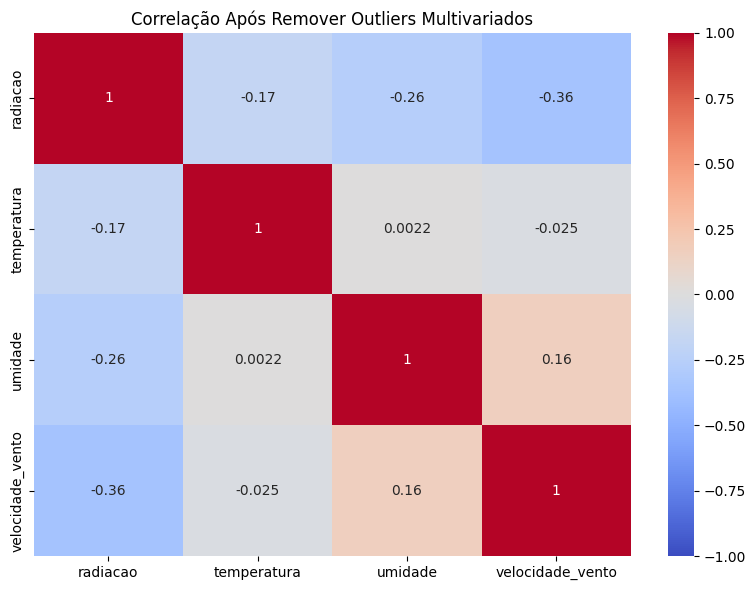

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_no_outliers_multi, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlação Após Remover Outliers Multivariados")
plt.tight_layout()

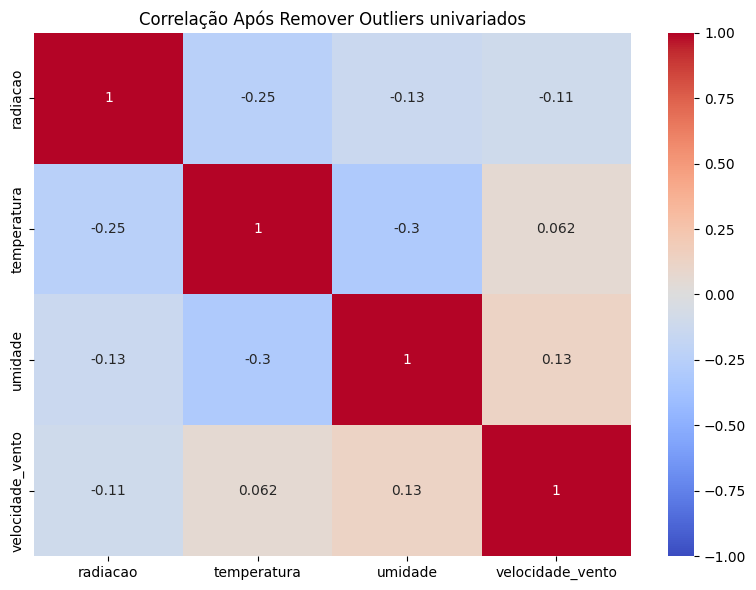

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_no_outliers_uni, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlação Após Remover Outliers univariados")
plt.tight_layout()

In [20]:
print("\nGerando visualizações para comparação...")

# Scatter plot: temperatura vs. radiacao
plot_scatter_with_outliers(df_imputed_custom, 'temperatura', 'radiacao', outliers_multi, outliers_uni_indices, 'scatter_temp_radiacao.png')

# Scatter plot: umidade vs. velocidade_vento
plot_scatter_with_outliers(df_imputed_custom, 'umidade', 'velocidade_vento', outliers_multi, outliers_uni_indices, 'scatter_umidade_vento.png')


Gerando visualizações para comparação...


In [21]:
# Validação dos Resultados
print("\nValidando resultados da imputação...")


Validando resultados da imputação...


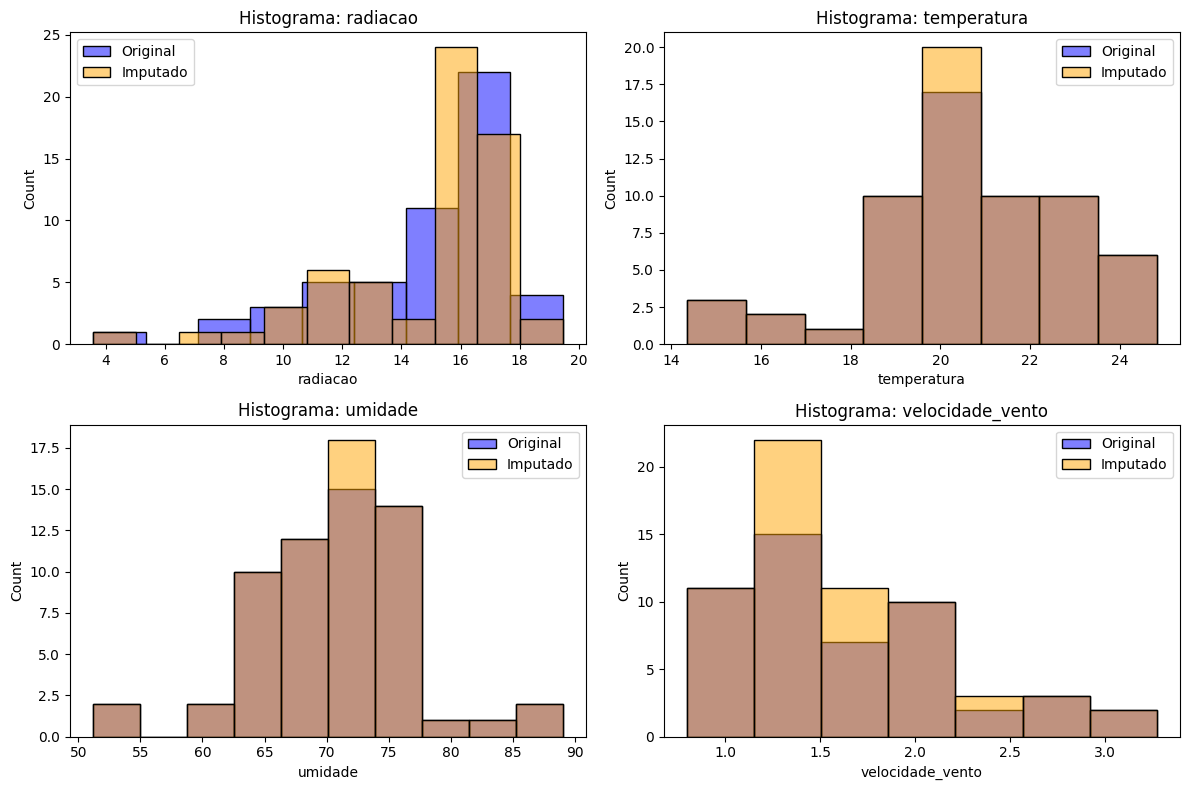

In [29]:
# Histogramas antes e depois da imputação
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], label='Original', alpha=0.5, color='blue')
    sns.histplot(df_imputed_custom[col], label='Imputado', alpha=0.5, color='orange')
    plt.title(f'Histograma: {col}')
    plt.legend()
plt.tight_layout()
#plt.savefig('histogramas_imputacao.png')
#plt.close()

([0, 1, 2, 3],
 [Text(0, 0, 'radiacao'),
  Text(1, 0, 'temperatura'),
  Text(2, 0, 'umidade'),
  Text(3, 0, 'velocidade_vento')])

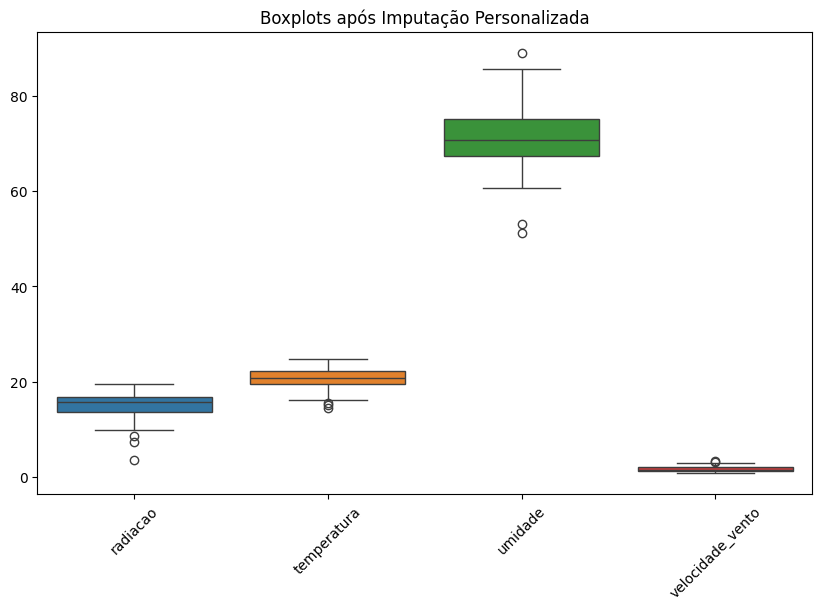

In [30]:
# Boxplots após imputação
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_imputed_custom)
plt.title('Boxplots após Imputação Personalizada')
plt.xticks(rotation=45)
#plt.savefig('boxplots_imputacao.png')
#plt.close()

In [24]:
# Calcular RMSE em valores não ausentes
rmse_results = {}
for col in df.columns:
    mask = df[col].notna()
    if mask.sum() > 0:
        rmse = np.sqrt(mean_squared_error(df[col][mask], df_imputed_custom[col][mask]))
        rmse_results[col] = rmse

print("\nRMSE por coluna (comparando valores não ausentes):")
for col, rmse in rmse_results.items():
    print(f"{col}: {rmse:.4f}")


RMSE por coluna (comparando valores não ausentes):
radiacao: 0.0000
temperatura: 0.0000
umidade: 0.0000
velocidade_vento: 0.0000


In [25]:
# Matrizes de correlação antes e depois da imputação
corr_before = df.corr()
corr_after = df_imputed_custom.corr()

print("\nCorrelações antes da imputação:")
print(corr_before)

print("\nCorrelações após a imputação:")
print(corr_after)


Correlações antes da imputação:
                  radiacao  temperatura   umidade  velocidade_vento
radiacao          1.000000    -0.181822 -0.269243         -0.346779
temperatura      -0.181822     1.000000  0.002195          0.002782
umidade          -0.269243     0.002195  1.000000          0.141806
velocidade_vento -0.346779     0.002782  0.141806          1.000000

Correlações após a imputação:
                  radiacao  temperatura   umidade  velocidade_vento
radiacao          1.000000    -0.173235 -0.260153         -0.363754
temperatura      -0.173235     1.000000  0.002195         -0.025241
umidade          -0.260153     0.002195  1.000000          0.158366
velocidade_vento -0.363754    -0.025241  0.158366          1.000000


In [ ]:
# Gerar heatmaps para correlações
# plot_correlation_heatmap(corr_before, 'Matriz de Correlação Antes da Imputação', 'corr_before.png')
# plot_correlation_heatmap(corr_after, 'Matriz de Correlação Após a Imputação', 'corr_after.png')

# print("\nHeatmaps de correlação salvos como 'corr_before.png', 'corr_after.png', 'corr_no_outliers_multi.png' e 'corr_no_outliers_uni.png'.")
# print("Scatter plots salvos como 'scatter_temp_radiacao.png' e 'scatter_umidade_vento.png'.")


Heatmaps de correlação salvos como 'corr_before.png', 'corr_after.png', 'corr_no_outliers_multi.png' e 'corr_no_outliers_uni.png'.
Scatter plots salvos como 'scatter_temp_radiacao.png' e 'scatter_umidade_vento.png'.


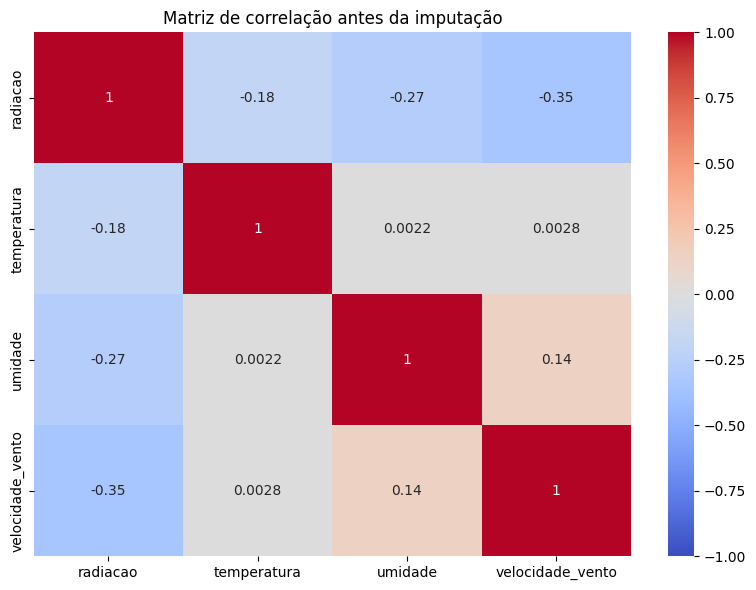

In [27]:
# Função para plotar a matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(corr_before, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Matriz de correlação antes da imputação")
plt.tight_layout()

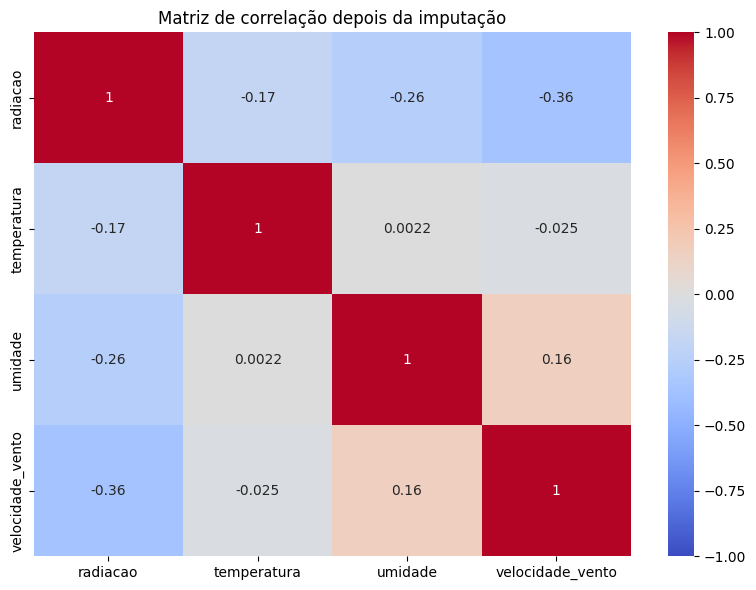

In [28]:
# Função para plotar a matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(corr_after, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Matriz de correlação depois da imputação")
plt.tight_layout()